# Modèle de détection de faux billet pour le compte de l'ONCFM

Ce notebook vise à présenter la démarche de création d'un algorithme de détection de faux billet pour le compte de l'ONCFM. Deux modèles seront testés : un reposant sur la méthode des k-means, l'autre sur une régression logistique.

## Introduction

### Importation des librairies

In [127]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from scipy  import stats
from scipy.stats import levene
import joblib

### Importation des données

In [64]:
df_billets = pd.read_csv('billets.csv', sep = ';')

### Description des données

In [65]:
df_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Nos 6 colonnes représentent des variables quantitatives qui désignent des dimensions pour les éléments constitutifs des billets de banque. On constate qu'il y a des valeurs manquantes pour la colonnes 'margin_low' grâce au count.

### Traitement des valeurs manquantes pour 'margin_low'

#### Isolation des valeurs manquantes

In [66]:
df_billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il y a 37 valeurs manquantes pour la colonne. Séparons les billets comprenant des données manquantes de ceux présentant toutes les données.

In [67]:
df_billets_nonull = df_billets.dropna() 
df_billets_nulls = df_billets[df_billets.isnull().any(axis=1)]

#### Matrice de corrélation 

Nous pouvons désormais analyser les liens entre les variables afin de déterminer si il est possible d'utiliser, comme nous a conseillé notre collègue, un modèle de régression linéaire pour prédire les données manquantes.

In [68]:
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<Axes: >

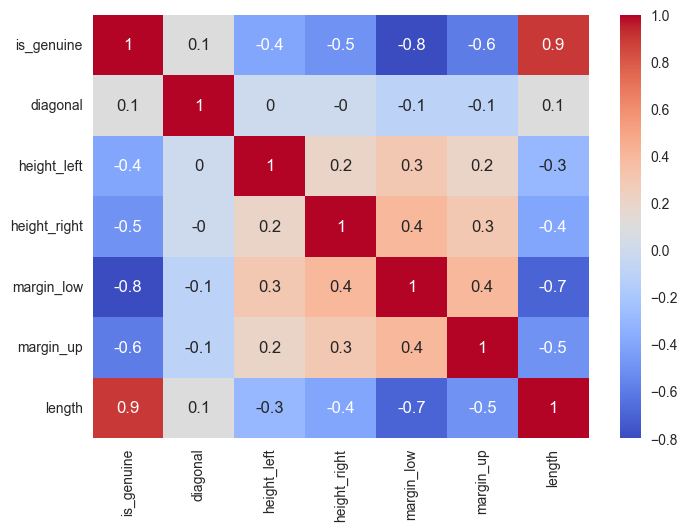

In [69]:
matrix = df_billets_nonull.corr().round(1)
sns.heatmap(data=matrix, annot=True, cmap="coolwarm")

On constate que d'après la matrice, 'margin_low' et 'length' sont fortement corrélés négativement ce qui nous permettra d'utiliser la variable 'length' pour prédire 'margin_low'. 

#### Régression linéaire simple et prédiction des valeurs manquantes

In [70]:
# On récupère les données et on les convertit en array pour faciliter la modélisation

X = df_billets_nonull[ "length"]
y = df_billets_nonull['margin_low']
X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

In [71]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un modèle de régression linéaire
regression = lr()

# Entraîner le modèle sur les données d'entraînement
regression.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred_lr1 = regression.predict(X_test)

# Évaluer la performance du modèle
score = regression.score(X_test, y_test)

# Afficher les résultats
print("Coefficient de régression : ", regression.coef_)
print("Terme d'interception : ", regression.intercept_)
print("Score du modèle : ", score)

Coefficient de régression :  [[-0.49896285]]
Terme d'interception :  [60.70502909]
Score du modèle :  0.5136070700267961


Le coefficient de régression suggère qu'une d'une diminution d'une unité pour la variable 'lenght' entraîne une diminution de 0.49896285 pour la variable 'margin_low'.

Le score du modèle témoigne de performances moyennes pour la prédiction des données manquantes sur le jeu de test.

#### Visualisation de la régression simple

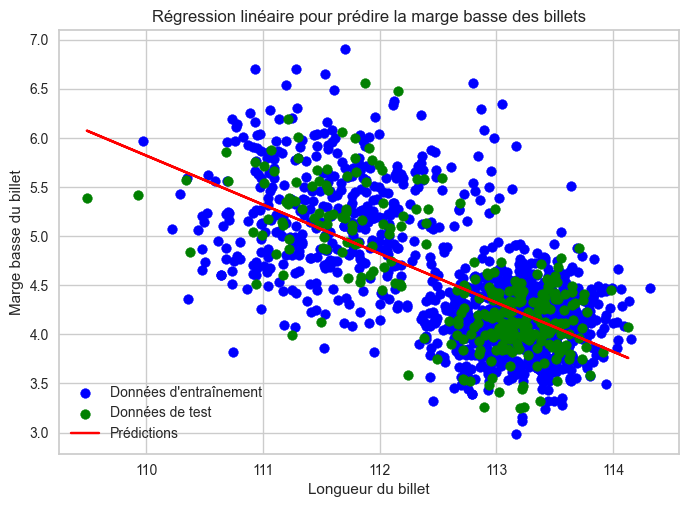

In [72]:
# Tracer les données d'entraînement
plt.scatter(X_train, y_train, color='blue', label='Données d\'entraînement')

# Tracer les données de test
plt.scatter(X_test, y_test, color='green', label='Données de test')

# Tracer les prédictions du modèle
plt.plot(X_test, y_pred_lr1, color='red', label='Prédictions')

# Ajouter des étiquettes d'axe et un titre
plt.xlabel('Longueur du billet')
plt.ylabel('Marge basse du billet')
plt.title('Régression linéaire pour prédire la marge basse des billets')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

#### Régression linéaire multiple et prédiction des valeurs manquantes

Les performances du modèle de regression linéaire simple basé sur une seule variable prédictive n'étant pas optimales, nous testerons la version basée sur plusieurs variables.

In [73]:
# On récupère les données et on les convertit en array pour faciliter la modélisation
X = df_billets_nonull[["diagonal", "height_left", "height_right", "margin_up", "length"]].values
y = df_billets_nonull['margin_low'].values

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un modèle de régression linéaire
regression = lr()

# Entraîner le modèle sur les données d'entraînement
regression.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred_test = regression.predict(X_test)

# Calculer les valeurs prédites des données d'entraînement
y_pred_train = regression.predict(X_train)


# Calculer les résidus pour les ensembles d'entraînement et de test
residus_train = y_train - regression.predict(X_train)
residus_test = y_test - y_pred_test

# Ajouter une colonne "residus" aux DataFrames d'entraînement et de test
df_train = pd.DataFrame(X_train, columns=["diagonal", "height_left", "height_right", "margin_up", "length"])
df_train["margin_low"] = y_train
df_train["residus"] = residus_train

df_test = pd.DataFrame(X_test, columns=["diagonal", "height_left", "height_right", "margin_up", "length"])
df_test["margin_low"] = y_test
df_test["residus"] = residus_test

# Afficher les résultats
print("Coefficient de régression :", regression.coef_)
print("Terme d'interception :", regression.intercept_)
print("Score du modèle :", regression.score(X_test, y_test))

Coefficient de régression : [-0.087151    0.15474474  0.25994669  0.29097436 -0.39898675]
Terme d'interception : 20.396009801378298
Score du modèle : 0.5457956683532402


Dans le cadre d'une regression multiple, les coefficients de regression indiquent le changement attendu pour la variable dépendante, pour chaque unité de changement dans la variable indépendante en supposant que les autres variables ne changent pas.

#### Analyse des résidus

On procède à l'analyse des résidus dans le cadre de notre modèle afin d'évaluer les hypothèses de régression.

##### Distribution des résidus

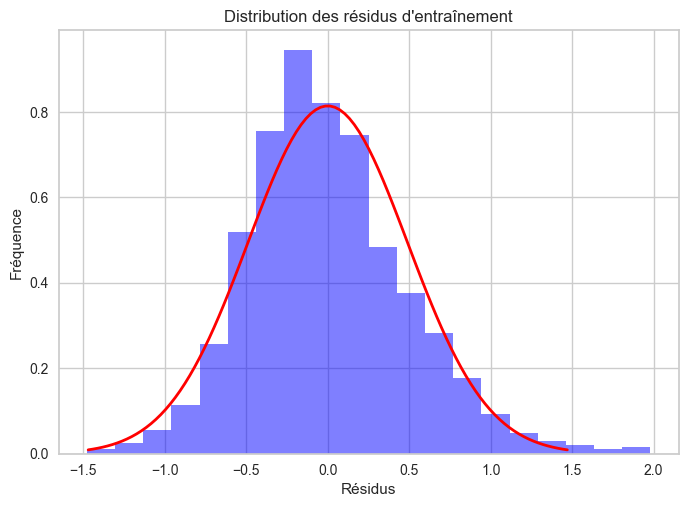

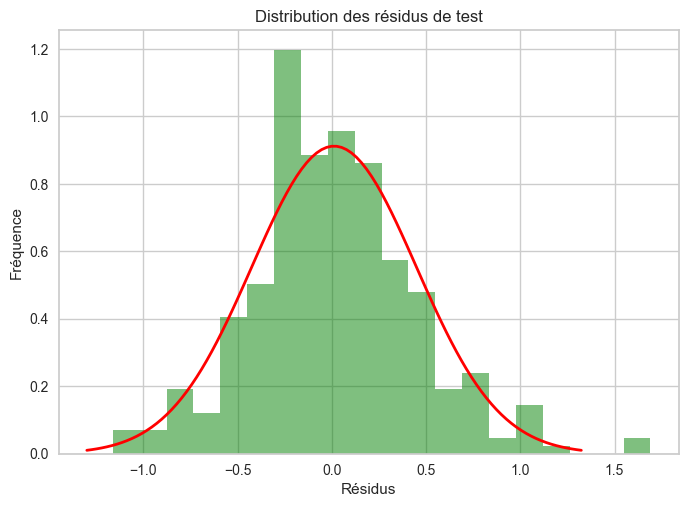

In [74]:
# Tracer un histogramme des résidus d'entraînement
plt.hist(residus_train, bins=20, color='blue', alpha=0.5, density=True)
plt.title("Distribution des résidus d'entraînement")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")

# Ajouter la courbe de normalité
mu, sigma = np.mean(residus_train), np.std(residus_train)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='red', linewidth=2)

plt.show()

# Tracer un histogramme des résidus de test
plt.hist(residus_test, bins=20, color='green', alpha=0.5, density=True)
plt.title("Distribution des résidus de test")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")

# Ajouter la courbe de normalité
mu, sigma = np.mean(residus_test), np.std(residus_test)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='red', linewidth=2)

plt.show()

On constate une distribution normale des résidus.

##### Homoscédasticité des résidus 

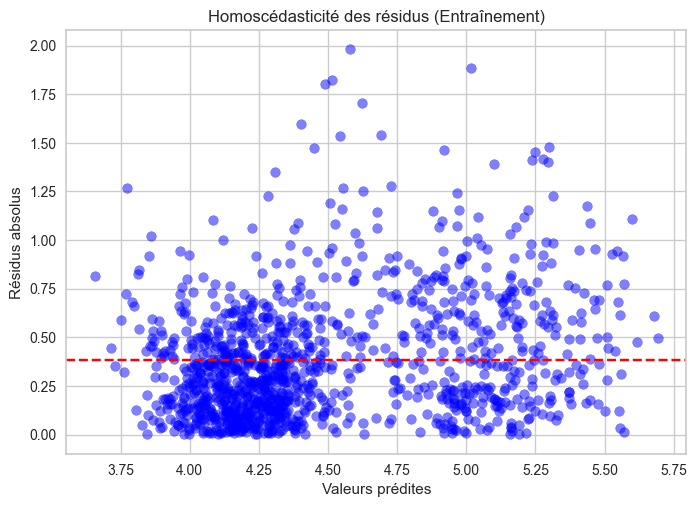

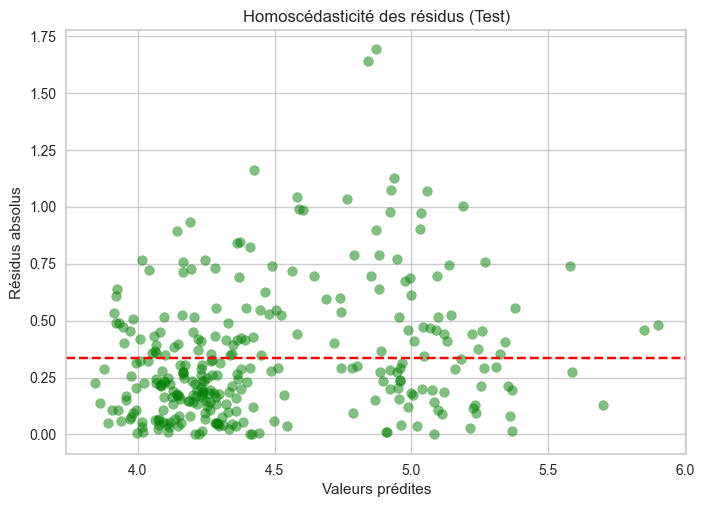

In [75]:
# Calculer les résidus absolus
residus_abs = np.abs(residus_train)

# Tracer le graphique d'homoscédasticité (résidus absolus vs. valeurs prédites)
plt.scatter(y_pred_train, residus_abs, color='blue', alpha=0.5)
plt.axhline(y=np.mean(residus_abs), color='red', linestyle='--')
plt.title("Homoscédasticité des résidus (Entraînement)")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus absolus")

plt.show()

# Calculer les résidus absolus des données de test
residus_abs_test = np.abs(residus_test)

# Tracer le graphique d'homoscédasticité des résidus absolus (résidus absolus vs. valeurs prédites)
plt.scatter(y_pred_test, residus_abs_test, color='green', alpha=0.5)
plt.axhline(y=np.mean(residus_abs_test), color='red', linestyle='--')
plt.title("Homoscédasticité des résidus (Test)")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus absolus")

plt.show()

La visualisation de la distribution des résidus laisse penser que l'homoscédasticité des résidus est rompue pour notre modèle.

Nous calculons la statistique de Levene pour évaluer l'homogénéité des variances entre les résidus et confirmer ou infirmer cela.

In [76]:
# Effectuer le test de Levene
statistic, p_value = levene(residus_train, residus_test)

# Afficher les résultats
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: 4.653096727023997
p-value: 0.0311602282723604


La statistique de Levene s'éloigne de 0 ce qui signifie que la variance diffère entre les groupes.
La p-value est inférieure au seuil de 0.05 ce qui suggère une violation de l'hypothèse d'homoscédasticité des résidus.

##### Performance et pertinence du modèle

Le score du modèle sur les données de test est supérieur à celui de la regression linéaire simple ce qui signifie de meilleures performances donc des prédictions plus justes. Cela dit la rupture de l'hypothèse de l'homoscédasticité implique potentiellement 3 choses :

- Biais des coefficients : Lorsque l'homoscédasticité est violée, les estimations des coefficients de régression peuvent être biaisées. 

- Erreur-type incorrecte : Lorsque les variances des résidus ne sont pas constantes, l'erreur-type utilisée pour les intervalles de confiance et les tests d'hypothèses peut être incorrecte.

- Mauvaise précision des prédictions : Lorsque l'homoscédasticité est violée, les prédictions du modèle peuvent être moins précises. 

Nous utiliserons ce modèle pour prédire les valeurs manquantes pour 'margin_low' mais il pourrait être judicieux d'explorer une autre méthode pour prédire les valeurs manquantes compte tenu de l'analyse des résidus et du score du modèle.

##### Application des prédictions au jeu de données pour remplacer les valeurs manquantes

In [77]:
# Charger les données pour faire des prédictions
X_test = df_billets_nulls[["diagonal", "height_left", "height_right", "margin_up", "length"]]

# Faire des prédictions sur les données
df_billets_nulls.loc[:, "margin_low"] = regression.predict(X_test.values)


In [133]:
# On concatene les 2 DF pour retrouver notre DF initial sans valeurs nulles

df_billets = pd.concat([df_billets_nonull, df_billets_nulls])
df_billets.to_csv('dfbilletsog.csv')
df_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483432,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659489,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


On constate que la prédiction n'a pas changé la moyenne affichée pour 'margin_low' lors du premier describe.

## Analyse descriptive des billets

In [79]:
# Info sur les billets

df_billets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


In [80]:
# On crée deux DF, l'un contenant les vrais et l'autre les faux billets

billets_true = df_billets[df_billets['is_genuine'] == True]
billets_false = df_billets[df_billets['is_genuine'] == False]

In [81]:
# Describe sur les billets_true

billets_true.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.118259,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.317532,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.910000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.120000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [82]:
# Describe sur les billets_false

billets_false.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.213778,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.550411,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.180000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.590000,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


### Analyse des caractéritiques des vrais / faux billets

In [83]:
# Groupby vrai / faux pour les billets 

print(df_billets.groupby('is_genuine').agg(Total = ('length', 'count')))

            Total
is_genuine       
False         500
True         1000


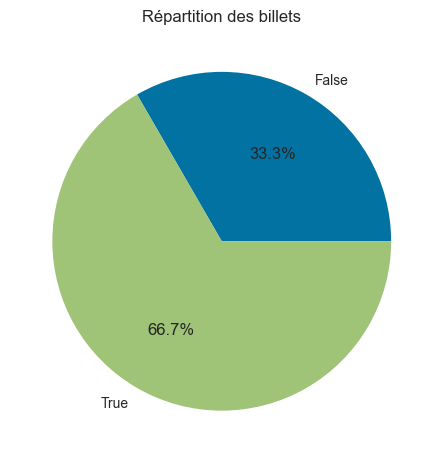

In [84]:
# % de vrais / faux représentés par un pie chart:

fig, ax = plt.subplots()
ax.pie(df_billets.groupby(["is_genuine"])["length"].count(),
        labels=["False","True"],
        autopct="%1.1f%%",)
plt.title("Répartition des billets")
plt.savefig('pie.png')
plt.show()

Il y a 66.7% de vrais billets dans le DF contre 33.3% de faux.

### Répartition dimension billets

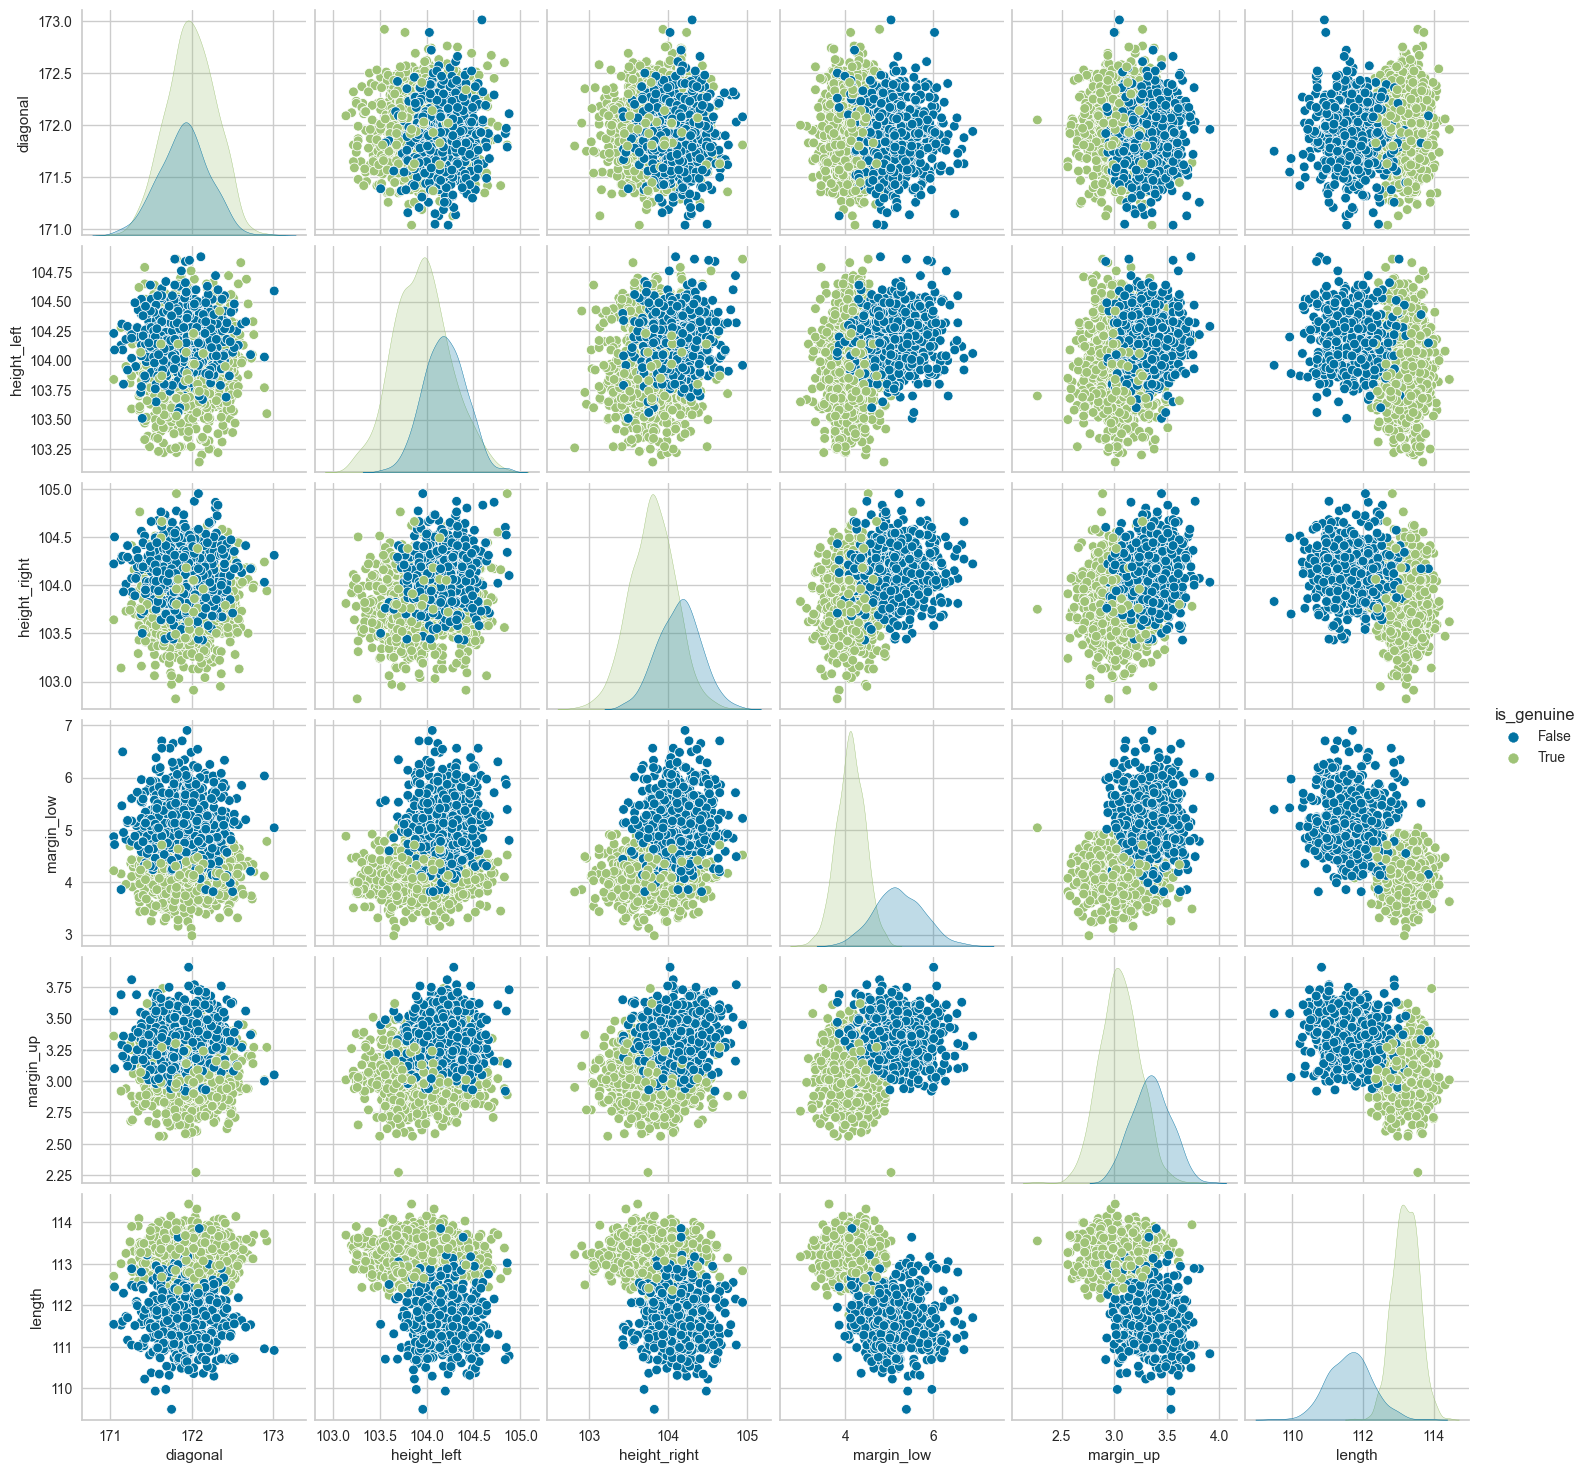

In [85]:
sns.pairplot(df_billets, hue="is_genuine")
plt.savefig('repartition.png')

Les vrais/faux billets sont concentrés pour chaque type dans une zone des graphiques. On constate que certains faux billets ont des caractéristiques de vrais billets pour certaines variables.

#### Matrice de corrélation après prédictions

<Axes: >

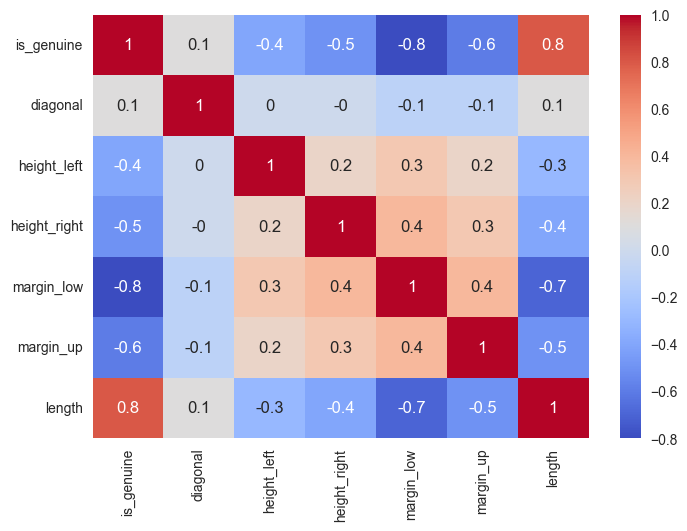

In [86]:
matrix = df_billets.corr().round(1)
sns.heatmap(data=matrix, annot=True, cmap="coolwarm")

La matrice de corrélation post-prediction est similaire à la précédente.

## Modèle k-means

### Standardisation et split des données

In [134]:
# On supprime la colonne is_genuine du DF pour effectuer le clustering 

df_sans_genuine = df_billets.drop(columns=['is_genuine'])
df_sans_genuine.to_csv("dfbillets.csv", sep=";", index=False)
df_sans_genuine

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.520000,2.89,112.83
1,171.46,103.36,103.66,3.770000,2.99,113.09
2,172.69,104.48,103.50,4.400000,2.94,113.16
3,171.36,103.91,103.94,3.620000,3.01,113.51
4,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...
1303,172.17,104.49,103.76,5.013806,2.93,111.21
1315,172.08,104.15,104.17,4.781467,3.40,112.29
1347,171.72,104.46,104.12,5.698913,3.61,110.31
1435,172.66,104.33,104.41,5.194886,3.56,111.47


'Is_genuine' est exclue car ce n'est pas une variable quantitative

In [131]:
# On standardise les données pour les rendre utilisables pour l'algorithme 

# Instancier un objet StandardScaler
scaler = StandardScaler()

# Standardiser les données en utilisant fit_transform() de StandardScaler
X_scaled = scaler.fit_transform(df_sans_genuine)

# Créer un nouveau DataFrame à partir des données standardisées
df_billets_scaled = pd.DataFrame(X_scaled, columns=df_sans_genuine.columns)

# Afficher le nouveau DataFrame
df_billets_scaled

In [90]:
y_km = df_billets['is_genuine']
X_km = df_billets_scaled[[
    "diagonal", "height_left", "height_right", "margin_low", "margin_up",
    "length"]]

# Division du jeu de données en ensemble d'entraînement, de validation et de test
X_train_val_km, X_test_km, y_train_val_km, y_test_km = train_test_split(X_km, y_km, test_size=0.2961, random_state=42)

# Division de l'ensemble d'entraînement et de validation en ensemble d'entraînement et de validation
X_train_km, X_val_km, y_train_km, y_val_km = train_test_split(X_train_val_km, y_train_val_km, test_size=0.2, random_state=42)

### Déterminer le nombre de clusters optimal

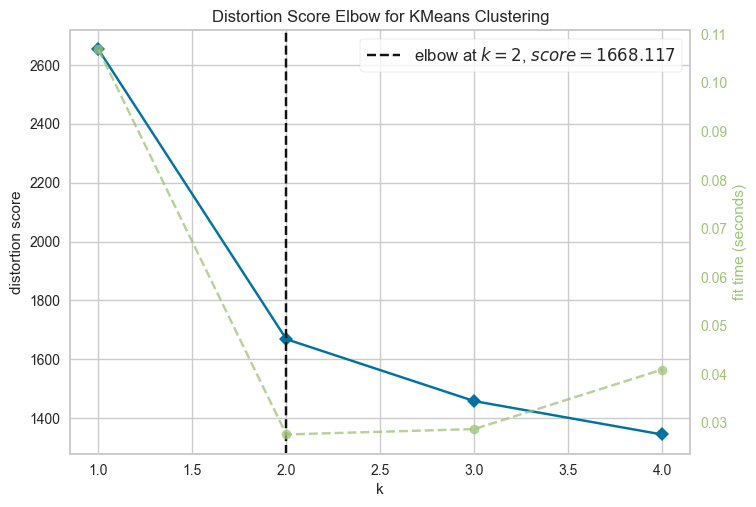

In [91]:
# Recherche du nombre de clusters optimal 
# Méthode du coude

kmeans = KMeans(n_init=10)

visualizer = KElbowVisualizer(kmeans, k=(1, 5))
visualizer.fit(X_test_km)
visualizer.show();

Le point d'inflexion du coude indique un nombre de cluster optimal de 2. 

In [92]:
# Recherche du nombre de clusters optimal 
# Méthode du score de silhouette 

# On crée une liste pour stocker les différents scores de silhouette
silhouette_scores = []

# On crée une boucle pour trouver le nombre de clusters qui a le plus haut score de silhouette
for n_clusters in range(2, 5):
    # Fitting du modèle de clustering KMeans
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_test_km)
    
    # Calcul du score de silhouette et ajout à la liste 
    silhouette_avg = silhouette_score(X_test_km, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    print(f"For {n_clusters} clusters, the silhouette score is {silhouette_avg:.4f}")


For 2 clusters, the silhouette score is 0.3454
For 3 clusters, the silhouette score is 0.2234
For 4 clusters, the silhouette score is 0.2007


Le score de silhouette le plus proche de 1 est pour 2 clusters ce qui corrobore les résultats de la méthode du coude.

Ces deux méthodes confirment l'hypothèse de 2 clusters, qui semblait logique si on se basait sur le contexte de notre analyse. En effet, il existait 2 types de billets dans notre DF, des vrais et des faux, qui pouvaient constituer chacun un cluster.

### Implémentation du clustering K-means


In [93]:
# Instanciation de l'algorithme KMeans avec 2 clusters
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)

# Entraînement du modèle sur les données d'entraînement
kmeans.fit(X_train_km)

# Prédiction des clusters sur les données de test
y_pred_km = kmeans.predict(X_test_km)

X_test_kmeans = X_test_km.copy()
X_test_kmeans["Cluster"] = y_pred_km

#### Matrice de confusion

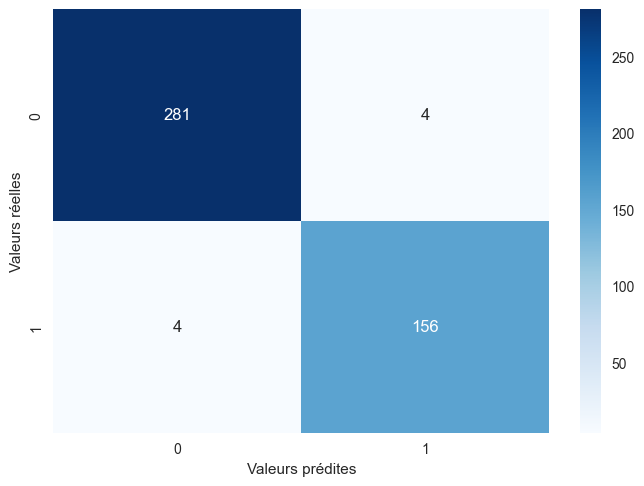

In [94]:
# Calcul de la matrice de confusion
confusion_km = confusion_matrix(y_test_km, y_pred_km)
confusion_km = np.flipud(confusion_km)

# Création de la heatmap
sns.heatmap(confusion_km, annot=True, fmt='d', cmap="Blues")

# Ajout des labels pour les axes x et y
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

# Affichage du graphique
plt.show()

In [ ]:
# Calcul des taux de faux positifs et faux négatifs

false_positive = round(4 / 156 * 100,2)
false_negative = round(4 / 281 * 100,2)

print(
    "Sur notre dataset, la méthode K-Mean nous donne un taux de faux positif à {}% ainsi qu'un taux de faux négatif à {}%."
    .format(false_positive, false_negative))

Sur notre dataset, la méthode K-Mean nous donne un taux de faux positif à 2.56% ainsi qu'un taux de faux négatif à 1.42%.


#### Evaluation des performances du modèle

In [95]:
# Evaluation des performances du modèle à l'aide de la métrique "adjusted_rand_score"

score = adjusted_rand_score(y_test_km, y_pred_km)
print("Le score d'adjusted_rand_score est :", score)

Le score d'adjusted_rand_score est : 0.9288033464937018


Le score est très élevé, ce qui signifie que l'algorithme est parvenu à identifier avec précision les regroupements naturels dasn les données et que les clusters sont cohérents.

## Regression logistique 

Nous réaliserons une régression logistique binaire car la variable dépendante ('is_genuine') est au format booléen et renvoie True ou False en résultat.

Une probabilité inférieure à 0.5 prédira 0 (Faux) tandis qu'une probabilité supérieure à 0.5 prédira 1 (Vrai).

In [96]:
# On utilise comme base les données standardisées via StandardScaler

df_billets_scaled.head()


,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.055467,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.082157,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.126552,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.309681,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.672612,1.417677,-0.158750


In [98]:
# Variable dépendante

y_log = df_billets["is_genuine"]
X_log = df_billets_scaled[["diagonal", "height_left", "height_right", "margin_low", "margin_up","length"]]

# Division en ensembles de données d'entraînement, de test et de validation

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.2, stratify=y_log, random_state=42)

X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(
    X_train_log, y_train_log, test_size=0.25, stratify=y_train_log, random_state=42)


### Première itération du modèle

In [99]:
# Création d'une instance de modèle
logreg = LogisticRegression()

# Entraînement du modèle sur les données d'entraînement
logreg.fit(X_train_log, y_train_log)

# Prédiction sur les données de test
y_pred_log = logreg.predict(X_test_log)

# Création d'un DF test contenant la colonne prédite 
X_test_logreg = X_test_log.copy()
X_test_logreg["is_genuine_pred"] = y_pred_log

#### Evaluation de la performance du modèle 

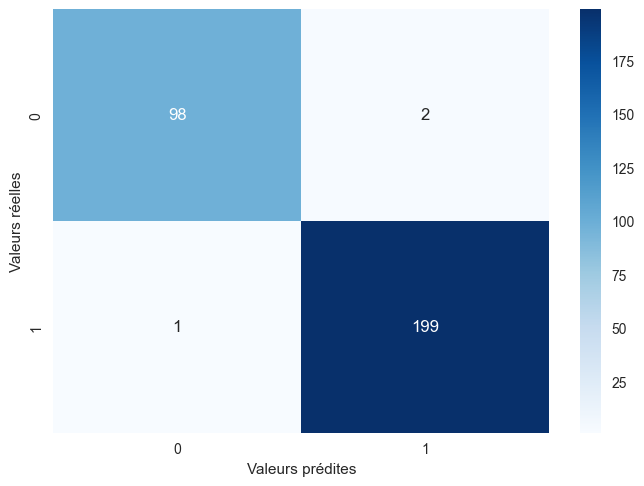

In [100]:
# Calcul de la matrice de confusion
confusion_log_1 = confusion_matrix(y_test_log, y_pred_log)

# Création de la heatmap
sns.heatmap(confusion_log_1, annot=True, fmt='d', cmap="Blues")

# Ajout des labels pour les axes x et y
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

# Affichage du graphique
plt.show()

In [101]:
false_negative = round(2 / 100 * 100, 2)
false_positive = round(1 / 200 * 100, 2)

print(
    """Sur notre dataset d'entraînement, notre modèle nous donne un taux de faux positif à {}% ainsi qu'un taux
de faux négatif à {}%."""
    .format(false_positive, false_negative))

Sur notre dataset d'entraînement, notre modèle nous donne un taux de faux positif à 0.5% ainsi qu'un taux
de faux négatif à 2.0%.


In [102]:
# Calculer le F1 score sur les données de test
f1 = f1_score(y_test_log, y_pred_log)

print("Le F1 score est :", f1)

Le F1 score est : 0.9925187032418954


Le taux de faux positifs et le F1 score affichés témoignent de très bonnes performances mais nous essaierons de faire varier le seuil de décision afin de tenter de les améliorer.

### Ajustement du seuil de décision

In [103]:
# Prédiction des probabilités sur les données de test
y_proba = logreg.predict_proba(X_test_log)[:, 1]

# Itération sur différents seuils de décision
for threshold in np.arange(0.1, 1, 0.1):
    # Prédiction sur les données de test avec le seuil de décision courant
    y_pred_log = (y_proba >= threshold).astype(int)
    # Calcul des métriques de performance avec le seuil de décision courant
    precision = precision_score(y_test_log, y_pred_log)
    recall = recall_score(y_test_log, y_pred_log)
    f1 = f1_score(y_test_log, y_pred_log)
    # Affichage des métriques de performance avec le seuil de décision courant
    print("Threshold : {:.1f}, Precision : {:.3f}, Recall : {:.3f}, F1 score : {:.3f}".format(
        threshold, precision, recall, f1))

Threshold : 0.1, Precision : 0.966, Recall : 1.000, F1 score : 0.983
Threshold : 0.2, Precision : 0.971, Recall : 1.000, F1 score : 0.985
Threshold : 0.3, Precision : 0.985, Recall : 1.000, F1 score : 0.993
Threshold : 0.4, Precision : 0.985, Recall : 1.000, F1 score : 0.993
Threshold : 0.5, Precision : 0.990, Recall : 0.995, F1 score : 0.993
Threshold : 0.6, Precision : 0.990, Recall : 0.995, F1 score : 0.993
Threshold : 0.7, Precision : 0.990, Recall : 0.995, F1 score : 0.993
Threshold : 0.8, Precision : 0.990, Recall : 0.990, F1 score : 0.990
Threshold : 0.9, Precision : 0.995, Recall : 0.980, F1 score : 0.987


Etant donné que nous souhaitons créer un modèle de classification de billets de banque, nous avons plutôt intérêt à ce que l'algorithme soit optimisé pour éviter à tout prix de classer des faux billets en vrais. Nous devons donc limiter au maximum les faux positifs et choisissons donc un seuil de décision avec une précision élevée et un rappel de 1. Nous choisissons donc 0.3.

### Predictions avec le nouveau seuil de décision

In [129]:
# Création d'un nouveau modèle de régression logistique avec le seuil de décision de 0.4
logreg_new = LogisticRegression(random_state=0, solver='liblinear', C=10, penalty='l1', class_weight='balanced')
logreg_new.fit(X_train_log, y_train_log)

# Enregistrement du modèle

joblib.dump(logreg_new, "modelogreg.pkl")

# Prédiction des probabilités positives pour les données de test
y_proba_new = logreg_new.predict_proba(X_test_log)[:, 1]

# Conversion des probabilités en classes prédites avec le seuil de décision de 0.4
y_pred_new = (y_proba_new >= 0.3).astype(int)

# Création d'un DF test contenant la colonne prédite 
X_test_log_opti = X_test_log.copy()
X_test_log_opti["is_genuine_pred"] = y_pred_new

#### Evaluation de la performance du modèle

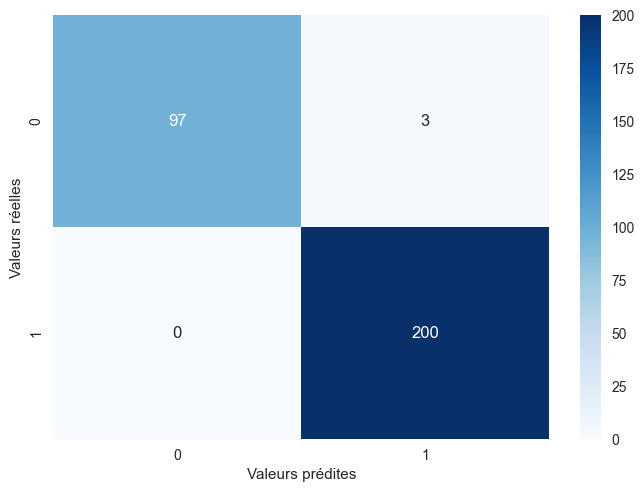

In [125]:
# Calcul de la matrice de confusion
confusion_log_2 = confusion_matrix(y_test_log, y_pred_new)

# Création de la heatmap
sns.heatmap(confusion_log_2, annot=True, fmt='d', cmap="Blues")

# Ajout des labels pour les axes x et y
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

# Affichage du graphique
plt.show()

In [126]:
false_negative = round(3 / 100 * 100, 2)
false_positive = round(0 / 200 * 100, 2)

print(
    """Sur notre dataset d'entraînement, notre modèle nous donne un taux de faux positif à {}% ainsi qu'un taux
de faux négatif à {}%."""
    .format(false_positive, false_negative))

Sur notre dataset d'entraînement, notre modèle nous donne un taux de faux positif à 0.0% ainsi qu'un taux
de faux négatif à 3.0%.


Le modèle avec le seuil de décision ajusté affiche 0 faux positifs, contre 1 pour la version initiale mais il affiche 3 faux négatifs contre 2 sur le modèle initial. L'algorithme semble donc plus performant dans la détection des faux billets.

## Conclusion

Nous avions 2 pistes de modèles à utiliser pour notre algorithme de détection des faux billets : Kmeans et régression logistique. Après avoir élaboré, implémenté et testé les performances des modèles, il semblerait que le modèle le plus performant soit la regression logistique dans le cadre de notre problème. 


La regression logistique avec plusieurs itérations et un seuil de décision ajusté a en effet affiché d'excellentes performantes en comparaison au modèle kmeans. 

Nos résultats sont cohérents avec le postulat que l'on aurait pu avoir au départ qui est qu'un algorithme supervisé, et en particulier un algorithme de régression logistique binaire, serait la meilleure méthode pour prédire les valeurs sous la forme de booléens (VRAI/FAUX) et par conséquent l'authenticité de billets de banque.